<a href="https://colab.research.google.com/github/nullvoid-ky/introduction-to-machine-learning-and-deep-learning/blob/main/Bankruptcy_PerModel_Balanced_Threshold.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Bankruptcy Prediction – Per-model runs + Data Balancing + Threshold Tuning
รันแต่ละโมเดลแยก cell + เครื่องมือแก้ **class imbalance (93/7)** และ **threshold tuning**


In [9]:
# ===== Setup & Installs (Kaggle usually has most of these; safe to re-run) =====
!pip -q install kagglehub shap lightgbm xgboost

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from typing import List

from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.metrics import accuracy_score, roc_auc_score
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.inspection import permutation_importance

import shap
import warnings
warnings.filterwarnings('ignore')


In [10]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("utkarshx27/american-companies-bankruptcy-prediction-dataset")

print("Path to dataset files:", path)

Using Colab cache for faster access to the 'american-companies-bankruptcy-prediction-dataset' dataset.
Path to dataset files: /kaggle/input/american-companies-bankruptcy-prediction-dataset


In [11]:
from kagglehub import KaggleDatasetAdapter, load_dataset

# >>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>
# Set the CSV file path **inside** the dataset (adjust if needed)
# Explore the dataset directory printed below to confirm the file name.
# >>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>
file_path = "/kaggle/input/american-companies-bankruptcy-prediction-dataset/american_bankruptcy.csv"

df = pd.read_csv(file_path)

print("Loaded shape:", df.shape)
print("Columns:\n", list(df.columns))
df.head()

Loaded shape: (78682, 21)
Columns:
 ['company_name', 'status_label', 'year', 'X1', 'X2', 'X3', 'X4', 'X5', 'X6', 'X7', 'X8', 'X9', 'X10', 'X11', 'X12', 'X13', 'X14', 'X15', 'X16', 'X17', 'X18']


,company_name,status_label,year,X1,X2,X3,X4,X5,X6,X7,...,X9,X10,X11,X12,X13,X14,X15,X16,X17,X18
0,C_1,alive,1999,511.267,833.107,18.373,89.031,336.018,35.163,128.348,...,1024.333,740.998,180.447,70.658,191.226,163.816,201.026,1024.333,401.483,935.302
1,C_1,alive,2000,485.856,713.811,18.577,64.367,320.590,18.531,115.187,...,874.255,701.854,179.987,45.790,160.444,125.392,204.065,874.255,361.642,809.888
2,C_1,alive,2001,436.656,526.477,22.496,27.207,286.588,-58.939,77.528,...,638.721,710.199,217.699,4.711,112.244,150.464,139.603,638.721,399.964,611.514
3,C_1,alive,2002,396.412,496.747,27.172,30.745,259.954,-12.410,66.322,...,606.337,686.621,164.658,3.573,109.590,203.575,124.106,606.337,391.633,575.592
4,C_1,alive,2003,432.204,523.302,26.680,47.491,247.245,3.504,104.661,...,651.958,709.292,248.666,20.811,128.656,131.261,131.884,651.958,407.608,604.467


In [12]:
# Load df (replace with your own CSV load if needed)
try:
    df  # noqa: F821
    print("✅ Found existing `df`.")
except NameError:
    import pandas as pd
    print("ℹ️ Creating a placeholder df. Replace with your real data load.")
    df = pd.DataFrame({
        "X8":[0.1,0.2,0.3,0.4],
        "X17":[1,2,3,4],
        "X3":[5,6,7,8],
        "X11":[0,1,0,1],
        "X15":[10,11,12,13],
        "X1":[2,3,4,5],
        "X6":[9,8,7,6],
        "status_label":["alive","failed","alive","failed"],
    })
print("df shape:", df.shape)


✅ Found existing `df`.
df shape: (78682, 21)


In [13]:
# Feature selection + map target
import numpy as np, pandas as pd
FEATURES = ["X8","X17","X3","X11","X10","X1","X6"]
TARGET   = "status_label"
if not set(FEATURES+[TARGET]).issubset(df.columns):
    missing = list(set(FEATURES+[TARGET]) - set(df.columns))
    raise ValueError(f"Missing columns: {missing}")
df[TARGET] = df[TARGET].astype(str).str.strip().str.lower().map({"alive":0,"failed":1}).astype(int)
X = df[FEATURES].copy()
y = df[TARGET].copy()
print("y ratio:", dict(pd.Series(y).value_counts(normalize=True).round(3)))


y ratio: {0: np.float64(0.934), 1: np.float64(0.066)}


In [14]:
# Imports
import warnings; warnings.filterwarnings("ignore")
import matplotlib.pyplot as plt
from abc import ABC, abstractmethod
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression, Perceptron
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.cluster import KMeans, AgglomerativeClustering
from sklearn.decomposition import PCA
from sklearn.metrics import accuracy_score, confusion_matrix, roc_auc_score, f1_score, precision_score, recall_score, roc_curve, auc
RANDOM_STATE = 42


In [15]:
# OOP classes
class BaseModel(ABC):
    def __init__(self, X, y, model_params=None, random_state=42):
        import pandas as pd
        from sklearn.preprocessing import StandardScaler
        self.X, self.y = X, y
        self.random_state = random_state
        self.model = None
        self.model_params = model_params or {}
        self.X_train = self.X_test = self.y_train = self.y_test = None
        self.scaler = StandardScaler()
        self.history = None
        self.is_fitted = False
    def split_data(self, test_size=0.2, scale=True):
        from sklearn.model_selection import train_test_split
        Xtr, Xte, ytr, yte = train_test_split(self.X, self.y, test_size=test_size, random_state=self.random_state, stratify=self.y)
        if scale:
            import pandas as pd
            self.X_train = pd.DataFrame(self.scaler.fit_transform(Xtr), columns=Xtr.columns)
            self.X_test  = pd.DataFrame(self.scaler.transform(Xte), columns=Xte.columns)
        else:
            self.X_train, self.X_test = Xtr, Xte
        self.y_train, self.y_test = ytr, yte
    @abstractmethod
    def build_model(self): ...
    def fit(self):
        if self.X_train is None: raise ValueError("Call split_data() first.")
        self.build_model()
        self.model.fit(self.X_train, self.y_train)
        self.is_fitted = True
        if hasattr(self.model, "loss_curve_"):
            self.history = {"loss_curve": self.model.loss_curve_}
        print(f"✅ {self.__class__.__name__} trained.")
    def evaluate(self):
        import numpy as np
        from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, f1_score, roc_auc_score
        if isinstance(self.model, (KMeans, AgglomerativeClustering)):
            return {"Note": "Unsupervised Model: Use specific clustering metrics."}
        if self.y_test is None or not self.is_fitted:
            return {"Error": "Model not fitted or Test data not available."}
        y_pred = self.model.predict(self.X_test)
        if len(np.unique(self.y_test)) == 2:
            tn, fp, fn, tp = confusion_matrix(self.y_test, y_pred).ravel()
            sensitivity = tp / (tp + fn) if (tp + fn) else 0.0
            specificity = tn / (tn + fp) if (tn + fp) else 0.0
            res = {
                "Loss (MLP only)": getattr(self.model, "loss_", "N/A"),
                "Confusion Matrix": [[int(tn), int(fp)],[int(fn), int(tp)]],
                "Accuracy": accuracy_score(self.y_test, y_pred),
                "Precision": precision_score(self.y_test, y_pred, zero_division=0),
                "Sensitivity (Recall)": sensitivity,
                "Specificity (TNR)": specificity,
                "F1-score": f1_score(self.y_test, y_pred, zero_division=0),
                "ROC AUC": "N/A",
            }
            if hasattr(self.model, "predict_proba"):
                y_proba = self.model.predict_proba(self.X_test)[:,1]
                res["ROC AUC"] = roc_auc_score(self.y_test, y_proba)
            return res
        else:
            return {"Accuracy": accuracy_score(self.y_test, y_pred)}
    def plot_roc(self, ax=None, label_prefix=""):
        from sklearn.metrics import roc_curve, auc
        if not hasattr(self.model, "predict_proba") or self.y_test is None:
            return
        y_proba = self.model.predict_proba(self.X_test)[:,1]
        fpr, tpr, _ = roc_curve(self.y_test, y_proba)
        roc_auc = auc(fpr, tpr)
        if ax is None:
            fig, ax = plt.subplots(1,1)
        ax.plot(fpr, tpr, label=f"{label_prefix} (AUC={roc_auc:.4f})")
        ax.plot([0,1],[0,1],"r--")

class LogisticRegressionModel(BaseModel):
    def build_model(self): self.model = LogisticRegression(random_state=self.random_state, **self.model_params)
class DecisionTreeModel(BaseModel):
    def build_model(self): self.model = DecisionTreeClassifier(random_state=self.random_state, **self.model_params)
class RandomForestModel(BaseModel):
    def build_model(self): self.model = RandomForestClassifier(random_state=self.random_state, **self.model_params)
class NaiveBayesModel(BaseModel):
    def build_model(self): self.model = GaussianNB(**self.model_params)
class SupportVectorMachineModel(BaseModel):
    def build_model(self): self.model = SVC(random_state=self.random_state, probability=True, **self.model_params)
class PerceptronModel(BaseModel):
    def build_model(self): self.model = Perceptron(random_state=self.random_state, **self.model_params)
class MLPModel(BaseModel):
    def build_model(self): self.model = MLPClassifier(random_state=self.random_state, **self.model_params)
class KMeanClustering(BaseModel):
    def build_model(self):
        n_clusters = self.model_params.pop("n_clusters", 2)
        self.model = KMeans(n_clusters=n_clusters, random_state=self.random_state, n_init=10, **self.model_params)
    def fit(self):
        if self.X_train is None: raise ValueError("Data not split.")
        self.build_model(); self.model.fit(self.X_train); self.is_fitted=True; print(f"✅ {self.__class__.__name__} trained.")
class AgglomerativeClusteringModel(BaseModel):
    def build_model(self):
        n_clusters = self.model_params.pop("n_clusters", 2)
        self.model = AgglomerativeClustering(n_clusters=n_clusters, **self.model_params)
    def fit(self):
        if self.X_train is None: raise ValueError("Data not split.")
        self.build_model(); self.model.fit(self.X_train); self.is_fitted=True; print(f"✅ {self.__class__.__name__} trained.")
class ReducedClassifierModel(BaseModel):
    def __init__(self, X, y, classifier_class, n_components, model_params=None, random_state=42):
        super().__init__(X, y, model_params, random_state); self.classifier_class=classifier_class; self.n_components=n_components
    def build_model(self):
        pca = PCA(n_components=self.n_components, random_state=self.random_state)
        if self.classifier_class == SVC:
            clf = SVC(random_state=self.random_state, probability=True, **self.model_params)
        else:
            clf = self.classifier_class(random_state=self.random_state, **self.model_params)
        self.model = Pipeline([("pca", pca), ("classifier", clf)])


In [16]:
# Controller
class ModelController:
    def __init__(self, X, y, test_size=0.2, random_state=42):
        self.X, self.y = X, y
        self.test_size, self.random_state = test_size, random_state
        self.models = self._initialize_models()
        self.results = {}
    def _initialize_models(self):
        svm_params  = {"C":10, "gamma":"auto", "class_weight":"balanced"}
        rf_params   = {"n_estimators":150, "class_weight":"balanced_subsample"}
        lr_params   = {"class_weight":"balanced"}
        dt_params   = {"class_weight":"balanced"}
        perc_params = {"class_weight":"balanced"}
        mlp_params  = {"hidden_layer_sizes":(50,), "max_iter":500}
        return {
            "Logistic Regression": LogisticRegressionModel(self.X, self.y, model_params=lr_params),
            "Decision Tree": DecisionTreeModel(self.X, self.y, model_params=dt_params),
            "Random Forest": RandomForestModel(self.X, self.y, model_params=rf_params),
            "Naïve Bayesian": NaiveBayesModel(self.X, self.y),
            "Support Vector Machine": SupportVectorMachineModel(self.X, self.y, model_params=svm_params),
            "Perceptron (SLP)": PerceptronModel(self.X, self.y, model_params=perc_params),
            "Multi-layer Perceptron (MLP)": MLPModel(self.X, self.y, model_params=mlp_params),
            "PCA(5) + RF": ReducedClassifierModel(self.X, self.y, RandomForestClassifier, n_components=5, model_params=rf_params),
            "PCA(5) + SVM": ReducedClassifierModel(self.X, self.y, SVC, n_components=5, model_params=svm_params),
            "K-Means Clustering (k=2)": KMeanClustering(self.X, self.y, model_params={"n_clusters":2}),
            "Agglomerative Clustering (k=2)": AgglomerativeClusteringModel(self.X, self.y, model_params={"n_clusters":2}),
        }
    def show_benchmarking(self):
        import pandas as pd
        classification = {k:v for k,v in self.results.items() if isinstance(v, dict) and ('Accuracy' in v or 'ROC AUC' in v)}
        if not classification:
            print("No classification results."); return
        df_results = pd.DataFrame.from_dict(classification, orient="index")
        metrics_order = ["Accuracy","ROC AUC","F1-score","Precision","Sensitivity (Recall)","Specificity (TNR)"]
        cols = [m for m in metrics_order if m in df_results.columns]
        print(df_results[cols].sort_values(by="Accuracy", ascending=False).to_string(float_format="{:.4f}".format))
    def plot_all_roc(self):
        fig = plt.figure(figsize=(12,8)); ax = plt.gca(); plotted=False
        for name,m in self.models.items():
            res = self.results.get(name, {})
            if isinstance(m,(KMeanClustering,AgglomerativeClusteringModel)): continue
            if res.get("ROC AUC") in ("N/A",None): continue
            try: m.plot_roc(ax=ax, label_prefix=name); plotted=True
            except: pass
        if plotted:
            ax.set_title("ROC Curve Comparison"); ax.set_xlabel("FPR"); ax.set_ylabel("TPR"); ax.legend(loc="lower right")
        else:
            print("No ROC Curves available.")
    def plot_loss_curves(self):
        fig = plt.figure(figsize=(8,6)); ax = plt.gca(); found=False
        for name,m in self.models.items():
            if isinstance(m, MLPModel) and hasattr(m.model,"loss_curve_") and m.model.loss_curve_ is not None:
                m.plot_performance_curve(ax=ax, label_prefix=name); found=True
        if found: ax.set_title("MLP Loss vs Epochs")
        else: print("No MLP loss curve.")


In [17]:
# Init controller
controller = ModelController(X=X, y=y, test_size=0.2, random_state=RANDOM_STATE)
list(controller.models.keys())


['Logistic Regression',
 'Decision Tree',
 'Random Forest',
 'Naïve Bayesian',
 'Support Vector Machine',
 'Perceptron (SLP)',
 'Multi-layer Perceptron (MLP)',
 'PCA(5) + RF',
 'PCA(5) + SVM',
 'K-Means Clustering (k=2)',
 'Agglomerative Clustering (k=2)']

In [18]:
# Split once & share
X_train_raw, X_test_raw, y_train, y_test = train_test_split(
    controller.X, controller.y, test_size=controller.test_size,
    random_state=controller.random_state, stratify=controller.y
)
scaler = StandardScaler()
X_train = pd.DataFrame(scaler.fit_transform(X_train_raw), columns=X_train_raw.columns)
X_test  = pd.DataFrame(scaler.transform(X_test_raw), columns=X_test_raw.columns)
shared_split = {"X_train": X_train, "X_test": X_test, "y_train": y_train, "y_test": y_test}
print("Before rebalance:", dict(y_train.value_counts(normalize=True).round(3)))


Before rebalance: {0: np.float64(0.934), 1: np.float64(0.066)}


In [19]:
# Rebalance (undersample/oversample/hybrid)
import pandas as pd, numpy as np
def rebalance_train(X, y, method="undersample", ratio=1.0, random_state=42):
    Xy = X.copy(); Xy["__y__"] = y.values
    df0, df1 = Xy[Xy["__y__"]==0], Xy[Xy["__y__"]==1]
    n0, n1 = len(df0), len(df1)
    if method=="undersample":
        n0_keep = max(int(n1/ratio),1); n0_keep=min(n0_keep,n0)
        df0_bal = df0.sample(n=n0_keep, random_state=random_state, replace=False); df1_bal=df1
    elif method=="oversample":
        n1_make = max(int(n0*ratio),1)
        df1_bal = df1.sample(n=n1_make, random_state=random_state, replace=True); df0_bal=df0
    elif method=="hybrid":
        n1_target = max(int(n0*ratio),1)
        df1_os = df1.sample(n=n1_target, random_state=random_state, replace=True) if n1 < n1_target else df1
        n0_keep = min(len(df0), len(df1_os))
        df0_us = df0.sample(n=n0_keep, random_state=random_state, replace=False)
        df0_bal, df1_bal = df0_us, df1_os
    else:
        raise ValueError("Unknown method")
    df_bal = pd.concat([df0_bal, df1_bal]).sample(frac=1.0, random_state=random_state).reset_index(drop=True)
    X_bal = df_bal.drop(columns=["__y__"]); y_bal = df_bal["__y__"].astype(int)
    return X_bal, y_bal

METHOD="undersample"; RATIO=1.0  # 1.0 -> 1:1
Xb, yb = rebalance_train(shared_split["X_train"], shared_split["y_train"], method=METHOD, ratio=RATIO, random_state=RANDOM_STATE)
shared_split["X_train"], shared_split["y_train"] = Xb, yb
print("After rebalance:", dict(yb.value_counts(normalize=True).round(3)))


After rebalance: {0: np.float64(0.5), 1: np.float64(0.5)}


In [20]:
# --- Logistic Regression ---
m = controller.models["Logistic Regression"]
m.X_train, m.X_test = shared_split["X_train"], shared_split["X_test"]
m.y_train, m.y_test = shared_split["y_train"], shared_split["y_test"]
m.fit()
controller.results["Logistic Regression"] = m.evaluate()
print(controller.results["Logistic Regression"])


✅ LogisticRegressionModel trained.
{'Loss (MLP only)': 'N/A', 'Confusion Matrix': [[4766, 9927], [139, 905]], 'Accuracy': 0.36036093283344983, 'Precision': 0.08354874446085672, 'Sensitivity (Recall)': np.float64(0.8668582375478927), 'Specificity (TNR)': np.float64(0.32437215000340297), 'F1-score': 0.15240821825530482, 'ROC AUC': np.float64(0.675545643884426)}


In [21]:
# --- Decision Tree ---
m = controller.models["Decision Tree"]
m.X_train, m.X_test = shared_split["X_train"], shared_split["X_test"]
m.y_train, m.y_test = shared_split["y_train"], shared_split["y_test"]
m.fit()
controller.results["Decision Tree"] = m.evaluate()
print(controller.results["Decision Tree"])


✅ DecisionTreeModel trained.
{'Loss (MLP only)': 'N/A', 'Confusion Matrix': [[8909, 5784], [380, 664]], 'Accuracy': 0.6083116222914151, 'Precision': 0.10297766749379653, 'Sensitivity (Recall)': np.float64(0.6360153256704981), 'Specificity (TNR)': np.float64(0.6063431566051861), 'F1-score': 0.17725573945541911, 'ROC AUC': np.float64(0.6211792411378421)}


In [22]:
# --- Random Forest ---
m = controller.models["Random Forest"]
m.X_train, m.X_test = shared_split["X_train"], shared_split["X_test"]
m.y_train, m.y_test = shared_split["y_train"], shared_split["y_test"]
m.fit()
controller.results["Random Forest"] = m.evaluate()
print(controller.results["Random Forest"])


✅ RandomForestModel trained.
{'Loss (MLP only)': 'N/A', 'Confusion Matrix': [[9947, 4746], [319, 725]], 'Accuracy': 0.6781470420029231, 'Precision': 0.13251690732955584, 'Sensitivity (Recall)': np.float64(0.6944444444444444), 'Specificity (TNR)': np.float64(0.6769890424011434), 'F1-score': 0.22256331542594013, 'ROC AUC': np.float64(0.7534236792196247)}


In [23]:
# --- Naïve Bayesian ---
m = controller.models["Naïve Bayesian"]
m.X_train, m.X_test = shared_split["X_train"], shared_split["X_test"]
m.y_train, m.y_test = shared_split["y_train"], shared_split["y_test"]
m.fit()
controller.results["Naïve Bayesian"] = m.evaluate()
print(controller.results["Naïve Bayesian"])


✅ NaiveBayesModel trained.
{'Loss (MLP only)': 'N/A', 'Confusion Matrix': [[1198, 13495], [43, 1001]], 'Accuracy': 0.13973438393594714, 'Precision': 0.06905353200883002, 'Sensitivity (Recall)': np.float64(0.9588122605363985), 'Specificity (TNR)': np.float64(0.08153542503232832), 'F1-score': 0.12882882882882882, 'ROC AUC': np.float64(0.5650794367896929)}


In [24]:
# --- Support Vector Machine ---
m = controller.models["Support Vector Machine"]
m.X_train, m.X_test = shared_split["X_train"], shared_split["X_test"]
m.y_train, m.y_test = shared_split["y_train"], shared_split["y_test"]
m.fit()
controller.results["Support Vector Machine"] = m.evaluate()
print(controller.results["Support Vector Machine"])


✅ SupportVectorMachineModel trained.
{'Loss (MLP only)': 'N/A', 'Confusion Matrix': [[4073, 10620], [112, 932]], 'Accuracy': 0.3180402872211984, 'Precision': 0.08067867036011081, 'Sensitivity (Recall)': np.float64(0.89272030651341), 'Specificity (TNR)': np.float64(0.2772068331858708), 'F1-score': 0.1479834868212131, 'ROC AUC': np.float64(0.6703227199440502)}


In [25]:
# --- Perceptron (SLP) ---
m = controller.models["Perceptron (SLP)"]
m.X_train, m.X_test = shared_split["X_train"], shared_split["X_test"]
m.y_train, m.y_test = shared_split["y_train"], shared_split["y_test"]
m.fit()
controller.results["Perceptron (SLP)"] = m.evaluate()
print(controller.results["Perceptron (SLP)"])


✅ PerceptronModel trained.
{'Loss (MLP only)': 'N/A', 'Confusion Matrix': [[11322, 3371], [559, 485]], 'Accuracy': 0.750270064179958, 'Precision': 0.12577800829875518, 'Sensitivity (Recall)': np.float64(0.46455938697318006), 'Specificity (TNR)': np.float64(0.7705710202137072), 'F1-score': 0.19795918367346937, 'ROC AUC': 'N/A'}


In [26]:
# --- Multi-layer Perceptron (MLP) ---
m = controller.models["Multi-layer Perceptron (MLP)"]
m.X_train, m.X_test = shared_split["X_train"], shared_split["X_test"]
m.y_train, m.y_test = shared_split["y_train"], shared_split["y_test"]
m.fit()
controller.results["Multi-layer Perceptron (MLP)"] = m.evaluate()
print(controller.results["Multi-layer Perceptron (MLP)"])


✅ MLPModel trained.
{'Loss (MLP only)': np.float64(0.6265150640715466), 'Confusion Matrix': [[7386, 7307], [283, 761]], 'Accuracy': 0.5176971468513694, 'Precision': 0.09432325235498265, 'Sensitivity (Recall)': np.float64(0.7289272030651341), 'Specificity (TNR)': np.float64(0.5026883549989791), 'F1-score': 0.1670324846356453, 'ROC AUC': np.float64(0.6831899648306476)}


In [27]:
# --- PCA(5) + RF ---
m = controller.models["PCA(5) + RF"]
m.X_train, m.X_test = shared_split["X_train"], shared_split["X_test"]
m.y_train, m.y_test = shared_split["y_train"], shared_split["y_test"]
m.fit()
controller.results["PCA(5) + RF"] = m.evaluate()
print(controller.results["PCA(5) + RF"])


✅ ReducedClassifierModel trained.
{'Loss (MLP only)': 'N/A', 'Confusion Matrix': [[9386, 5307], [348, 696]], 'Accuracy': 0.6406557793734511, 'Precision': 0.11594202898550725, 'Sensitivity (Recall)': np.float64(0.6666666666666666), 'Specificity (TNR)': np.float64(0.6388075954536173), 'F1-score': 0.19753086419753085, 'ROC AUC': np.float64(0.7086472289955886)}


In [28]:
# --- PCA(5) + SVM ---
m = controller.models["PCA(5) + SVM"]
m.X_train, m.X_test = shared_split["X_train"], shared_split["X_test"]
m.y_train, m.y_test = shared_split["y_train"], shared_split["y_test"]
m.fit()
controller.results["PCA(5) + SVM"] = m.evaluate()
print(controller.results["PCA(5) + SVM"])


✅ ReducedClassifierModel trained.
{'Loss (MLP only)': 'N/A', 'Confusion Matrix': [[4333, 10360], [136, 908]], 'Accuracy': 0.3330367922729872, 'Precision': 0.08058217962371317, 'Sensitivity (Recall)': np.float64(0.8697318007662835), 'Specificity (TNR)': np.float64(0.2949023344449738), 'F1-score': 0.147498375568551, 'ROC AUC': np.float64(0.6718376332149723)}


In [29]:
# --- K-Means Clustering (k=2) ---
m = controller.models["K-Means Clustering (k=2)"]
m.X_train, m.X_test = shared_split["X_train"], shared_split["X_test"]
m.y_train, m.y_test = shared_split["y_train"], shared_split["y_test"]
m.fit()
controller.results["K-Means Clustering (k=2)"] = m.evaluate()
print(controller.results["K-Means Clustering (k=2)"])


✅ KMeanClustering trained.
{'Note': 'Unsupervised Model: Use specific clustering metrics.'}


In [30]:
# --- Agglomerative Clustering (k=2) ---
m = controller.models["Agglomerative Clustering (k=2)"]
m.X_train, m.X_test = shared_split["X_train"], shared_split["X_test"]
m.y_train, m.y_test = shared_split["y_train"], shared_split["y_test"]
m.fit()
controller.results["Agglomerative Clustering (k=2)"] = m.evaluate()
print(controller.results["Agglomerative Clustering (k=2)"])


✅ AgglomerativeClusteringModel trained.
{'Note': 'Unsupervised Model: Use specific clustering metrics.'}


In [31]:
# Threshold tuning helpers
import numpy as np
from sklearn.metrics import precision_recall_fscore_support, confusion_matrix
def find_best_threshold(y_true, y_proba, metric="f1"):
    y_true = np.asarray(y_true).astype(int)
    thresholds = np.linspace(0.01, 0.99, 99)
    best_t, best_val = 0.5, -1.0
    want_recall_at_prec = metric.startswith("recall@prec>=")
    prec_floor = None
    if want_recall_at_prec:
        prec_floor = float(metric.split(">=")[1])
    for t in thresholds:
        y_hat = (y_proba >= t).astype(int)
        p, r, f1, _ = precision_recall_fscore_support(y_true, y_hat, average="binary", zero_division=0)
        val = f1 if metric=="f1" else (r if (want_recall_at_prec and p>=prec_floor) else -1.0)
        if val > best_val:
            best_val, best_t = val, t
    return best_t, best_val

def evaluate_at_threshold(y_true, y_proba, threshold):
    y_pred = (y_proba >= threshold).astype(int)
    cm = confusion_matrix(y_true, y_pred)
    tn, fp, fn, tp = cm.ravel()
    acc = (tp+tn)/cm.sum()
    prec = tp/(tp+fp) if (tp+fp) else 0.0
    rec  = tp/(tp+fn) if (tp+fn) else 0.0
    f1   = 2*prec*rec/(prec+rec) if (prec+rec) else 0.0
    return {"threshold": float(threshold), "cm": cm.tolist(), "accuracy": float(acc), "precision": float(prec), "recall": float(rec), "f1": float(f1)}

# Example:
# name = "Random Forest"
# m = controller.models[name]
# y_proba = m.model.predict_proba(shared_split["X_test"])[:,1]
# t_best, val = find_best_threshold(shared_split["y_test"], y_proba, metric="f1")
# print("best threshold:", t_best, "score:", val)
# print("default 0.50:", evaluate_at_threshold(shared_split["y_test"], y_proba, 0.50))
# print("best:", evaluate_at_threshold(shared_split["y_test"], y_proba, t_best))


In [32]:
controller.show_benchmarking()

                              Accuracy ROC AUC  F1-score  Precision  Sensitivity (Recall)  Specificity (TNR)
Perceptron (SLP)                0.7503     N/A    0.1980     0.1258                0.4646             0.7706
Random Forest                   0.6781  0.7534    0.2226     0.1325                0.6944             0.6770
PCA(5) + RF                     0.6407  0.7086    0.1975     0.1159                0.6667             0.6388
Decision Tree                   0.6083  0.6212    0.1773     0.1030                0.6360             0.6063
Multi-layer Perceptron (MLP)    0.5177  0.6832    0.1670     0.0943                0.7289             0.5027
Logistic Regression             0.3604  0.6755    0.1524     0.0835                0.8669             0.3244
PCA(5) + SVM                    0.3330  0.6718    0.1475     0.0806                0.8697             0.2949
Support Vector Machine          0.3180  0.6703    0.1480     0.0807                0.8927             0.2772
Naïve Bayesian     

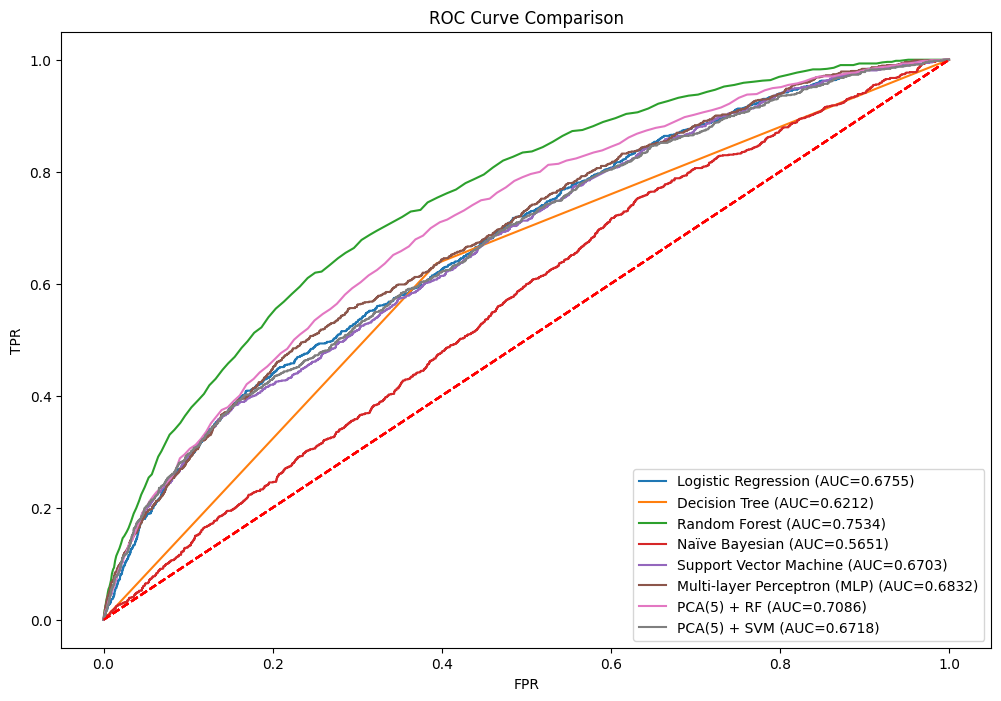

In [33]:
controller.plot_all_roc()

AttributeError: 'MLPModel' object has no attribute 'plot_performance_curve'

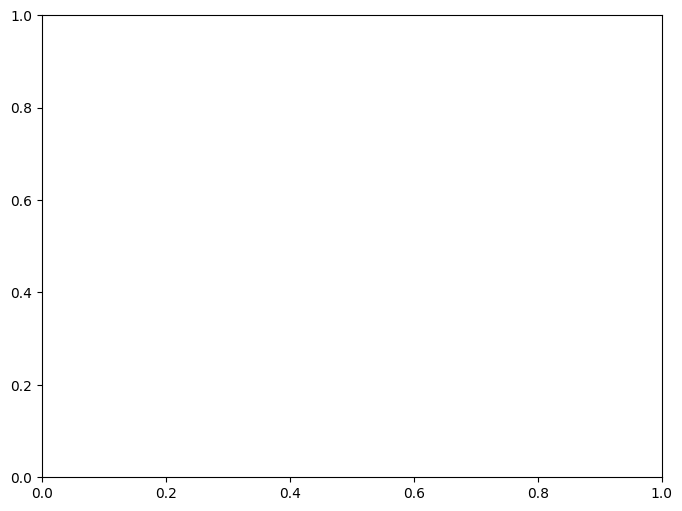

In [35]:
controller.plot_loss_curves()